In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

In [121]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM, Conv1D, MaxPooling1D, SpatialDropout1D, Dropout, Activation
from tensorflow.keras.optimizers import Adam

In [3]:
from text_cleaning import text_cleaning

# Cleaning of training data

In [4]:
train_data = pd.read_csv('train.csv')
train_data

,tweets,class
0,Be aware dirty step to get money #staylight ...,figurative
1,#sarcasm for #people who don't understand #diy...,figurative
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative
3,@wilw Why do I get the feeling you like games?...,figurative
4,-@TeacherArthurG @rweingarten You probably jus...,figurative
...,...,...
81403,Photo: Image via We Heart It http://t.co/ky8Nf...,sarcasm
81404,I never knew..I better put this out to the Uni...,sarcasm
81405,hey just wanted to say thanks @ puberty for le...,sarcasm
81406,I'm sure coverage like the Fox News Special “T...,sarcasm


In [16]:
train_data.columns = ['tweets', 'fos_class']       # the name 'class' is changed because it is already defined in python
train_data = train_data.sample(frac=1, random_state=123).reset_index(drop=True)   # shuffling the dataset
train_data

,tweets,fos_class
0,#socialtimes #news Foodworthy Image-Based Food...,regular
1,Watching Trainwreck then realizing my life is ...,irony
2,After the 9/16 #GOPDebate @ronaldreagan40 look...,regular
3,true 😜if you don't speak fluent sarcasm there'...,figurative
4,How to host Wordpress http://t.co/ZYOw8hfYO6 #...,regular
...,...,...
81403,That's surely enough to stop #ISIS\n#sarcasm ...,figurative
81404,Just been lectured on need to find non-polluti...,irony
81405,#chocolate at 1 a.m. :D #living #late #lol htt...,regular
81406,Reservation project has lost the requirement t...,figurative


In [17]:
# checking nan values
train_data.isna().sum()

tweets       0
fos_class    0
dtype: int64

In [18]:
# data points for each figure of speech
train_data.fos_class.value_counts()

figurative    21238
irony         20894
sarcasm       20681
regular       18595
Name: fos_class, dtype: int64

In [19]:
'''
clean_train_data = train_data.copy()

for i in tqdm(range(len(train_data))):
    clean_train_data.tweets[i] = str(text_cleaning(train_data.tweets[i]))
    
clean_train_data.to_csv('clean_train_data.csv', index=False)
    '''

clean_train_data = pd.read_csv('clean_train_data.csv')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 81408/81408 [06:01<00:00, 225.07it/s]


In [22]:
clean_train_data

,tweets,fos_class
0,socialtimes news foodworthy imagebased food ra...,regular
1,watching trainwreck realizing life train wreck...,irony
2,916 gopdebate look snap poll tell,regular
3,true dont speak fluent sarcasm theres good cha...,figurative
4,host wordpress wordpress education design tech...,regular
...,...,...
81403,thats surely enough stop isis sarcasm,figurative
81404,lectured need find nonpolluting ways travel pu...,irony
81405,chocolate 1 living late lol,regular
81406,reservation project lost requirement finalized...,figurative


# Tokenization of tweets

In [23]:
vocab_size = 10000
max_length = 35
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [24]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(clean_train_data.tweets.to_list())

In [25]:
tokenizer.word_index.items()

dict_items([('<OOV>', 1), ('sarcasm', 2), ('irony', 3), ('ironic', 4), ('news', 5), ('im', 6), ('love', 7), ('like', 8), ('people', 9), ('peace', 10), ('late', 11), ('humor', 12), ('education', 13), ('get', 14), ('politics', 15), ('drugs', 16), ('dont', 17), ('one', 18), ('funny', 19), ('day', 20), ('good', 21), ('lol', 22), ('know', 23), ('time', 24), ('great', 25), ('sarcastic', 26), ('cant', 27), ('gopdebate', 28), ('see', 29), ('really', 30), ('us', 31), ('new', 32), ('today', 33), ('would', 34), ('oh', 35), ('life', 36), ('right', 37), ('work', 38), ('well', 39), ('think', 40), ('go', 41), ('never', 42), ('way', 43), ('got', 44), ('make', 45), ('thats', 46), ('want', 47), ('need', 48), ('much', 49), ('back', 50), ('going', 51), ('2', 52), ('via', 53), ('thanks', 54), ('say', 55), ('night', 56), ('man', 57), ('better', 58), ('first', 59), ('best', 60), ('youre', 61), ('last', 62), ('fun', 63), ('u', 64), ('someone', 65), ('sure', 66), ('world', 67), ('didnt', 68), ('even', 69), ('s

In [26]:
len(tokenizer.word_index.items())

72189

In [27]:
train_sequences = tokenizer.texts_to_sequences(clean_train_data.tweets.to_list())
train_sequences[345]

[111, 1, 3619, 5052, 29, 1357, 3008, 2428, 1357, 123, 36, 4]

In [28]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_padded[345]

array([ 111,    1, 3619, 5052,   29, 1357, 3008, 2428, 1357,  123,   36,
          4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

# Tokenization of labels

In [112]:
label_maping = {'figurative':0,
                 'sarcasm':1,
                 'irony':2,
                 'regular':3}
y_train = list()
for i in range(len(clean_train_data)):
    y_train.append(np.eye(4)[label_maping[clean_train_data.fos_class[i]]])

y_train = np.array(y_train, dtype=int)
y_train

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

# Mapping tweets with glove word embeddings

In [30]:
embeddings = {}
glove = open('glove.6B.200d.txt', 'r', encoding = 'utf-8').read()

In [31]:
for line in tqdm(glove.split("\n")):
    values = line.split(" ")
    word = values[0]
    indices = np.asarray(values[1: ], dtype='float32')
    embeddings[word] = indices

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 400001/400001 [00:20<00:00, 19119.44it/s]


In [32]:
embedding_dim = 200
emb_matrix = np.zeros((vocab_size+1, embedding_dim)) 
for word, i in tokenizer.word_index.items():
    if i<vocab_size+1:
        embedding_vec = embeddings.get(word) 
        if embedding_vec is not None: 
            emb_matrix[i] = embedding_vec 
        
emb_matrix.shape

(10001, 200)

In [33]:
emb_matrix[2]

array([ 0.62538999,  0.46568999,  0.60732001, -0.47839999, -0.32909   ,
        0.48936   , -0.37059   ,  0.34226   , -0.10937   ,  0.68344998,
       -0.19043   ,  0.65208   , -0.30407   ,  0.10339   , -0.069518  ,
        0.15511   ,  0.25751001, -0.097239  ,  0.49634001, -0.13178   ,
        0.1505    , -0.44466001,  0.16622999,  0.0043739 , -0.20187999,
       -0.64469999, -1.23979998,  0.042317  , -0.12778001, -0.52511001,
       -1.02160001,  0.060753  ,  0.25141999,  0.70152003,  0.073605  ,
       -0.75171   ,  0.26137   , -0.40204   , -0.088056  ,  0.18095   ,
        0.46641999,  0.050578  ,  0.036427  , -0.13031   , -0.088021  ,
       -0.43279999,  0.080362  ,  0.54430002,  0.79525   ,  0.25384   ,
       -0.17290001, -0.30636999,  0.015178  ,  0.69357002,  0.41382   ,
        0.34064001, -0.15185   ,  0.57411999, -0.62405998, -0.35705999,
        0.37202999,  0.072245  ,  0.22316   ,  0.53113002,  0.32233   ,
        0.97631001, -0.018428  , -0.38812   ,  0.63393003, -0.09

# Model training

In [69]:
print(train_padded.shape,y_train.shape)

(81408, 35) (81408, 4)


In [128]:
model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights= [emb_matrix], trainable=False),
    LSTM(128, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='sigmoid')
    ])


optimizer = Adam(learning_rate=0.00001)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 35, 200)           2000200   
_________________________________________________________________
lstm_28 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 260       
Total params: 2,177,164
Trainable params: 176,964
Non-trainable params: 2,000,200
_____________________________________

In [129]:
history = model.fit(train_padded, y_train, validation_split=0.2, epochs = 20, batch_size=32)

Train on 65126 samples, validate on 16282 samples
Epoch 1/20
65126/65126 [==============================] - 16s 252us/sample - loss: 0.5525 - accuracy: 0.7582 - val_loss: 0.4194 - val_accuracy: 0.8019
Epoch 2/20
65126/65126 [==============================] - 16s 240us/sample - loss: 0.3755 - accuracy: 0.8147 - val_loss: 0.3057 - val_accuracy: 0.8542
Epoch 3/20
65126/65126 [==============================] - 15s 235us/sample - loss: 0.2995 - accuracy: 0.8499 - val_loss: 0.2733 - val_accuracy: 0.8642
Epoch 4/20
65126/65126 [==============================] - 16s 240us/sample - loss: 0.2801 - accuracy: 0.8562 - val_loss: 0.2632 - val_accuracy: 0.8665
Epoch 5/20
65126/65126 [==============================] - 16s 248us/sample - loss: 0.2722 - accuracy: 0.8586 - val_loss: 0.2591 - val_accuracy: 0.8677
Epoch 6/20
65126/65126 [==============================] - 16s 249us/sample - loss: 0.2681 - accuracy: 0.8600 - val_loss: 0.2569 - val_accuracy: 0.8682
Epoch 7/20
65126/65126 [====================

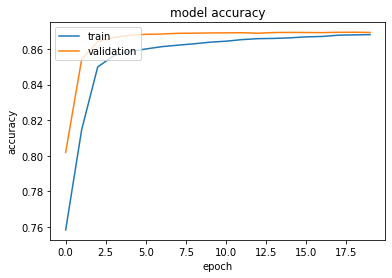

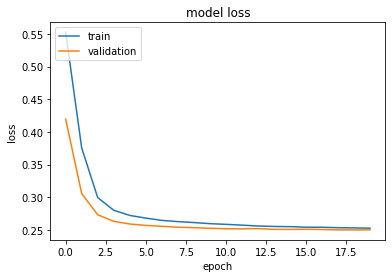

In [130]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Cleaning of test data

In [38]:
test_data = pd.read_csv('test.csv')
test_data

,tweets,class
0,no one ever predicted this was going to happen...,figurative
1,@Stooshie its as closely related as Andrews or...,figurative
2,I find it ironic when Vegans say they love foo...,figurative
3,Quick rt that throwing money vine I've not see...,figurative
4,"yep, keep adding me to your #devops lists.... ...",figurative
...,...,...
8123,Why yes I will totally submit my photos to a s...,sarcasm
8124,Test on a Saturday! Thank you uni! #sarcasm @ ...,sarcasm
8125,Listening to @StephenKing's Misery isn't at al...,sarcasm
8126,@mmcpatt There you go being kind again #sarcas...,sarcasm


In [39]:
test_data.columns = ['tweets', 'fos_class']       # the name 'class' is changed because it is already defined in python
# test_data = test_data.sample(frac=1, random_state=123).reset_index(drop=True)   # no need of shuffling
test_data

,tweets,fos_class
0,no one ever predicted this was going to happen...,figurative
1,@Stooshie its as closely related as Andrews or...,figurative
2,I find it ironic when Vegans say they love foo...,figurative
3,Quick rt that throwing money vine I've not see...,figurative
4,"yep, keep adding me to your #devops lists.... ...",figurative
...,...,...
8123,Why yes I will totally submit my photos to a s...,sarcasm
8124,Test on a Saturday! Thank you uni! #sarcasm @ ...,sarcasm
8125,Listening to @StephenKing's Misery isn't at al...,sarcasm
8126,@mmcpatt There you go being kind again #sarcas...,sarcasm


In [40]:
# checking nan values
test_data.isna().sum()

tweets       2
fos_class    9
dtype: int64

In [41]:
# replacing nan values with 0
test_data.tweets = test_data.tweets.replace(np.nan, 0)
test_data.fos_class = test_data.fos_class.replace(np.nan, 'regular')

In [42]:
# data points for each figure of speech
test_data.fos_class.value_counts()

irony         2111
sarcasm       2105
figurative    2044
regular       1868
Name: fos_class, dtype: int64

In [43]:
'''
clean_test_data = test_data.copy()

for i in tqdm(range(len(test_data))):
    clean_test_data.tweets[i] = str(text_cleaning(test_data.tweets[i]))
    
clean_test_data.to_csv('clean_test_data.csv', index=False)
    '''

clean_test_data = pd.read_csv('clean_test_data.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8128/8128 [00:27<00:00, 299.62it/s]


In [44]:
clean_test_data

,tweets,fos_class
0,one ever predicted going happen sarcasm,figurative
1,closely related andrews original claim evoluti...,figurative
2,find ironic vegans say love food irony,figurative
3,quick rt throwing money vine ive seen 30 times...,figurative
4,yep keep adding devops lists justsaying infose...,figurative
...,...,...
8123,yes totally submit photos shitty online magazi...,sarcasm
8124,test saturday thank uni sarcasm griffith unive...,sarcasm
8125,listening misery isnt disconcerting sarcasm,sarcasm
8126,go kind sarcasm standup4kids,sarcasm


In [45]:
# Tokenization of tweets

vocab_size = 10000
max_length = 35
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer2 = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer2.fit_on_texts(clean_test_data.tweets.to_list())

test_sequences = tokenizer2.texts_to_sequences(clean_test_data.tweets.to_list())

test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Tokenization of labels

label_maping = {'figurative':0,
                 'sarcasm':1,
                 'irony':2,
                 'regular':3}
y_test = list()
for i in range(len(clean_test_data)):
    y_test.append(np.eye(4)[label_maping[clean_test_data.fos_class[i]]])

y_test = np.array(y_test, dtype=int)
y_test

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [141]:
score = model.evaluate(test_padded, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

8128/8128 [==============================] - 1s 125us/sample - loss: 0.3169 - accuracy: 0.8651
Test Loss: 0.3169429479917378
Test Accuracy: 0.8650652


In [131]:
predictions = model.predict(test_padded)

In [146]:
predictions[:10]

array([[3.3834365e-01, 6.7115402e-01, 2.5313906e-03, 8.4880547e-04],
       [3.3739269e-01, 6.7074329e-01, 2.4725937e-03, 7.9561392e-04],
       [3.3998182e-01, 1.5918631e-03, 6.6959971e-01, 1.1406580e-03],
       [3.2734236e-01, 6.7637390e-01, 1.8796204e-03, 5.0228147e-04],
       [3.4075069e-01, 1.6015986e-03, 6.6933197e-01, 1.0926317e-03],
       [3.4792069e-01, 6.4883620e-01, 3.9655464e-03, 9.3986018e-04],
       [3.4496287e-01, 6.6564524e-01, 3.1325761e-03, 1.1345678e-03],
       [3.3176312e-01, 6.7626262e-01, 2.0283367e-03, 5.9764402e-04],
       [3.3133128e-01, 6.7572683e-01, 2.0138945e-03, 5.8199622e-04],
       [3.3582863e-01, 6.7203349e-01, 2.3795667e-03, 7.4793422e-04]],
      dtype=float32)

In [133]:
model.evaluate(test_padded, y_test, verbose=2)

8128/8128 - 1s - loss: 0.3169 - accuracy: 0.8651


[0.3169429479917378, 0.8650652]

In [143]:
pd.Series(np.argmax(predictions[:], axis=1)).value_counts()

2    3152
1    3017
3    1945
0      14
dtype: int64

In [80]:
np.argmax(y_test[:], axis=1)

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [89]:
pd.Series(np.argmax(y_test[:], axis=1)).value_counts()

2    2111
1    2105
0    2044
3    1868
dtype: int64